In [1]:
# conda install -y gensim
# run cell
# conda uninstall -y boto
# conda install -y boto

import glob
import os
import numpy as np
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.wrappers import FastText
import pandas as pd
import pymorphy2
import re
from tqdm import tqdm
import _pickle as cPickle
import matplotlib.pyplot as plt

## Настройки

In [10]:
# Путь к папке с сохраненными данными
data_folder = 'sem2012_padding'

# Путь к папке, куда положить модель
model_folder = 'ententen13_3_hinge'

# # Путь к папке с сохраненными данными
# data_folder = 'rutent2'

# # Путь к папке, куда положить модель
# model_folder = 'rutent2_3'

# Настройки сети
GRAD_CLIP = 100
N_HIDDEN = 200
NUM_EPOCHS = 50
LEARNING_RATE = .0001
EPOCH_SIZE = 100

EMBEDDING_SIZE = 100
MAX_SEQ_LENGTH = 30  # максимальное количество слов в предложении
N_BATCH = 128  # размер батча

## Загрузка датасета из файлов

In [168]:
X = cPickle.load(open(os.path.join(data_folder, "X_train.pkl"), "rb"))
# X_ = cPickle.load(open(os.path.join(data_folder, "X_train1.pkl"), "rb"))
# X = np.concatenate((X, X_), axis=0)
y = cPickle.load(open(os.path.join(data_folder, "y_train.pkl"), "rb"))
X_test = cPickle.load(open(os.path.join(data_folder, "X_test.pkl"), "rb"))
y_test = cPickle.load(open(os.path.join(data_folder, "y_test.pkl"), "rb"))
texts = cPickle.load(open(os.path.join(data_folder, "texts.pkl"), "rb"))

# X = cPickle.load(open(os.path.join(data_folder, "X_train.pkl"), "rb"))
# X_ = cPickle.load(open(os.path.join(data_folder, "X_train1.pkl"), "rb"))
# X = np.concatenate((X, X_), axis=0)
# y = cPickle.load(open(os.path.join(data_folder, "y_train.pkl"), "rb"))
# X_test = cPickle.load(open(os.path.join(data_folder, "X_test.pkl"), "rb"))
# y_test = cPickle.load(open(os.path.join(data_folder, "y_test.pkl"), "rb"))
# texts = cPickle.load(open(os.path.join(data_folder, "texts.pkl"), "rb"))

In [169]:
# y = np.array([np.array(target)[:, 0] for target in y])
# y_test = np.array([np.array(target)[:, 0] for target in y_test])

In [170]:
y = np.delete(y, 1, axis=2)
y_test = np.delete(y_test, 1, axis=2)

In [171]:
y[y < 0.5] = -1
y_test[y_test < 0.5] = -1
#y_test = np.argmin(y_test, axis=2)

In [172]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("texts length:", len(texts))

X shape: (4309, 30, 200)
y shape: (4309, 30, 1)
X_test shape: (1847, 30, 200)
y_test shape: (1847, 30, 1)
texts length: 6156


In [173]:
# Проверим наличие GPU

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15728975609246575807
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 139460608
locality {
  bus_id: 1
}
incarnation: 9308131407026218061
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


## Построение архитектуры сети

In [174]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Activation, InputLayer, Dropout, Flatten
from keras.optimizers import Adagrad, Adam
from keras.regularizers import l2, l1
from keras.models import model_from_json
from keras.callbacks import History
from keras.callbacks import TensorBoard

from time import time

In [175]:
model = Sequential()

# Архитектура сети
model.add(InputLayer(input_shape=(MAX_SEQ_LENGTH, EMBEDDING_SIZE * 2)))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model.add(Dense(units=1, activation='sigmoid'))
adam = Adam()

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['binary_accuracy', 'categorical_accuracy'])  # 'adam', 'accuracy'
# model.compile(loss='binary_crossentropy', optimizer=adagrad, metrics=['categorical_accuracy'])  # 'adam', 'accuracy'

In [176]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 30, 200)           0         
_________________________________________________________________
bidirectional_35 (Bidirectio (None, 30, 256)           336896    
_________________________________________________________________
dense_19 (Dense)             (None, 30, 1)             257       
Total params: 337,153
Trainable params: 337,153
Non-trainable params: 0
_________________________________________________________________


## Обучение

In [177]:
# Logging
tensorboard = TensorBoard(log_dir="logs/ententen13_binary/{}".format(time()))

# tensorboard --logdir=logs/

In [178]:
%%time

try:
    fit_history = model.fit(X, y, batch_size=N_BATCH, epochs=200, validation_split=0.2, verbose=0, callbacks=[tensorboard])
    
except KeyboardInterrupt:
    pass

CPU times: user 7min 8s, sys: 22 s, total: 7min 30s
Wall time: 5min 28s


In [43]:
fit_history.history.keys()

dict_keys(['val_loss', 'val_binary_accuracy', 'val_categorical_accuracy', 'loss', 'binary_accuracy', 'categorical_accuracy'])

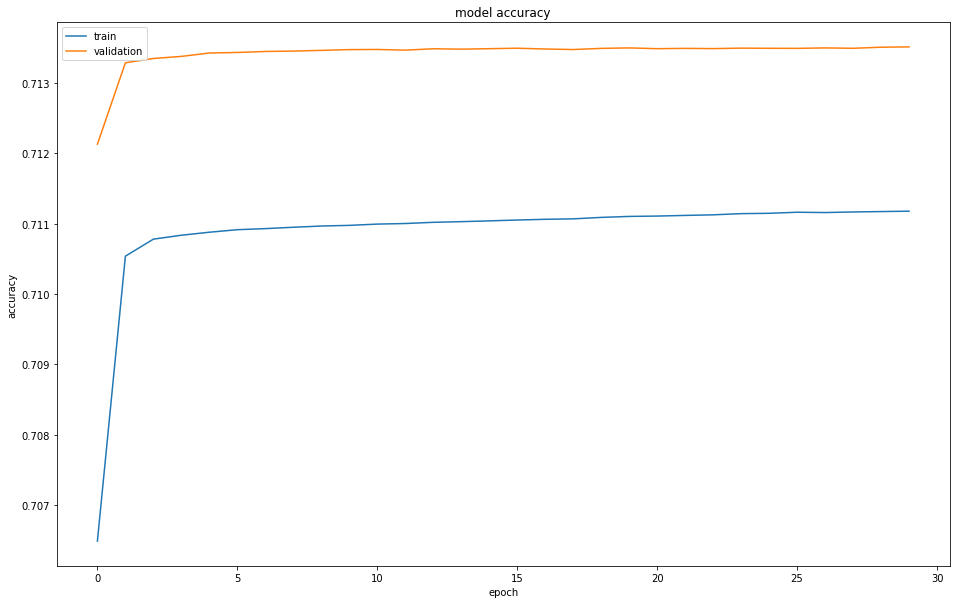

In [44]:
# График для accuracy

plt.figure(figsize=(16, 10))
plt.plot(fit_history.history['binary_accuracy'])
plt.plot(fit_history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

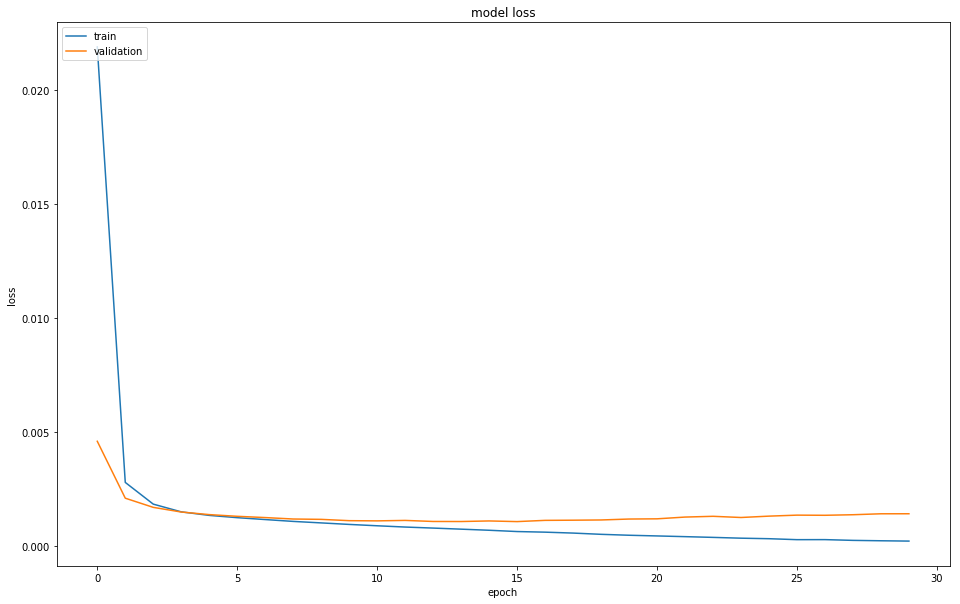

In [45]:
# График для loss

plt.figure(figsize=(16, 10))
plt.plot(fit_history.history['loss'])
plt.plot(fit_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [46]:
np.savetxt(os.path.join(model_folder, 'fit_history_loss.out'), fit_history.history['loss'], delimiter=',')
np.savetxt(os.path.join(model_folder, 'fit_history_val_loss.out'), fit_history.history['val_loss'], delimiter=',')
np.savetxt(os.path.join(model_folder, 'fit_history_acc.out'), fit_history.history['binary_accuracy'], delimiter=',')
np.savetxt(os.path.join(model_folder, 'fit_history_val_acc.out'), fit_history.history['val_binary_accuracy'], delimiter=',')
np.savetxt(os.path.join(model_folder, 'fit_history_catacc.out'), fit_history.history['categorical_accuracy'], delimiter=',')
np.savetxt(os.path.join(model_folder, 'fit_history_val_catacc.out'), 
           fit_history.history['val_categorical_accuracy'], delimiter=',')

## Evaluation

In [21]:
scores = model.evaluate(X_test, y_test, verbose=0)
scores

[0.009824039492177266, 0.9950911359136403, 0.9950911359136403]

In [36]:
scores

[0.0019405318685219446, 0.710570936932285, 0.4214508615476433]

## Сохранение модели в файл

In [179]:
# Сохраним модель

model_json = model.to_json()

with open(os.path.join(model_folder, "model.json"), "w") as json_file:
    json_file.write(model_json)

model.save_weights(os.path.join(model_folder, "model.h5"))